## Demonstrate full circle wide field imaging

This include prediction of components, inversion, point source fitting. We will compare the output images with the input models, looking for closeness in flux and position.

In [ ]:
% matplotlib inline

import os
import sys

sys.path.append(os.path.join('..', '..'))

results_dir = './results'
os.makedirs(results_dir, exist_ok=True)

from matplotlib import pylab

pylab.rcParams['figure.figsize'] = (10.0, 10.0)
pylab.rcParams['image.cmap'] = 'rainbow'

import numpy

from astropy.coordinates import SkyCoord
from astropy.time import Time
from astropy import units as u
from astropy.wcs.utils import pixel_to_skycoord

from arl.visibility.base import create_visibility
from arl.visibility.operations import sum_visibility
from arl.visibility.iterators import vis_timeslices, vis_wslices
from arl.util.testing_support import create_named_configuration
from arl.util.timing import timing

from matplotlib import pyplot as plt

from arl.skycomponent.operations import create_skycomponent, find_skycomponents, \
    find_nearest_component, insert_skycomponent
from arl.image.operations import show_image, export_image_to_fits, qa_image, smooth_image
from arl.image.iterators import image_raster_iter
from arl.util.testing_support import create_named_configuration
from arl.imaging import advise_wide_field, create_image_from_visibility, predict_skycomponent_visibility
from arl.imaging.imaging_context import invert_function, predict_function
from arl.data.polarisation import PolarisationFrame

import logging

log = logging.getLogger()
log.setLevel(logging.DEBUG)
log.addHandler(logging.StreamHandler(sys.stdout))


backend module://ipykernel.pylab.backend_inline version unknown


Construct the SKA1-LOW core configuration

In [8]:
lowcore = create_named_configuration('LOWBD2-CORE')

We create the visibility. This just makes the uvw, time, antenna1, antenna2, weight columns in a table

In [9]:
times = numpy.array([-3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0]) * (numpy.pi / 12.0)
frequency = numpy.array([1e8])
channel_bandwidth = numpy.array([1e6])
reffrequency = numpy.max(frequency)
phasecentre = SkyCoord(ra=+15.0 * u.deg, dec=-45.0 * u.deg, frame='icrs', equinox='J2000')
vt = create_visibility(lowcore, times, frequency, channel_bandwidth=channel_bandwidth,
                       weight=1.0, phasecentre=phasecentre, 
                       polarisation_frame=PolarisationFrame('stokesI'))

create_visibility: 95865 rows, 0.010 GB
create_visibility: 95865 rows, 0.010 GB


In [10]:
advice = advise_wide_field(vt, wprojection_planes=1)

advise_wide_field: Maximum wavelength 2.998 (meters)
advise_wide_field: Maximum wavelength 2.998 (meters)
advise_wide_field: Minimum wavelength 2.998 (meters)
advise_wide_field: Minimum wavelength 2.998 (meters)
advise_wide_field: Maximum baseline 262.6 (wavelengths)
advise_wide_field: Maximum baseline 262.6 (wavelengths)
advise_wide_field: Station/antenna diameter 35.0 (meters)
advise_wide_field: Station/antenna diameter 35.0 (meters)
advise_wide_field: Primary beam 0.085655 (rad) 4.908 (deg)
advise_wide_field: Primary beam 0.085655 (rad) 4.908 (deg)
advise_wide_field: Image field of view 0.513930 (rad) 29.446 (deg)
advise_wide_field: Image field of view 0.513930 (rad) 29.446 (deg)
advise_wide_field: Synthesized beam 0.003808 (rad) 0.218 (deg)
advise_wide_field: Synthesized beam 0.003808 (rad) 0.218 (deg)
advise_wide_field: Cellsize 0.001269 (rad) 0.073 (deg)
advise_wide_field: Cellsize 0.001269 (rad) 0.073 (deg)
advice_wide_field: Npixels per side = 405
advice_wide_field: Npixels per

Fill in the visibility with exact calculation of a number of point sources

create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Parsing parameters to get definition of WCS
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 999999.99999 Hz
create_image_from_visibility: Defining single channel Image at <SkyCoord (ICRS): (ra, dec) in deg
    (15., -45.)>, starting frequency 100000000.0 Hz, and bandwidth 999999.99999 Hz
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: uvmax = 262.634709 wavelengths
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Critical cellsize = 0.001904 radians, 0.109079 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
create_image_from_visibility: Cellsize          = 0.001000 radians, 0.057296 degrees
Spacing in pixels = 32
Spaci

Component at (112.000000, 112.000000) [0-rel] <SkyCoord (ICRS): (ra, dec) in deg
    (16.31764664, -45.90931658)>
insert_skycomponent: Using insert method Nearest
insert_skycomponent: Using insert method Nearest
Component at (80.000000, 112.000000) [0-rel] <SkyCoord (ICRS): (ra, dec) in deg
    (18.95148298, -45.84967813)>
Component at (80.000000, 112.000000) [0-rel] <SkyCoord (ICRS): (ra, dec) in deg
    (18.95148298, -45.84967813)>
insert_skycomponent: Using insert method Nearest
insert_skycomponent: Using insert method Nearest
Component at (48.000000, 112.000000) [0-rel] <SkyCoord (ICRS): (ra, dec) in deg
    (21.58097973, -45.73040913)>
Component at (48.000000, 112.000000) [0-rel] <SkyCoord (ICRS): (ra, dec) in deg
    (21.58097973, -45.73040913)>
insert_skycomponent: Using insert method Nearest
insert_skycomponent: Using insert method Nearest
Component at (16.000000, 112.000000) [0-rel] <SkyCoord (ICRS): (ra, dec) in deg
    (24.20334715, -45.55152143)>
Component at (16.000000, 11

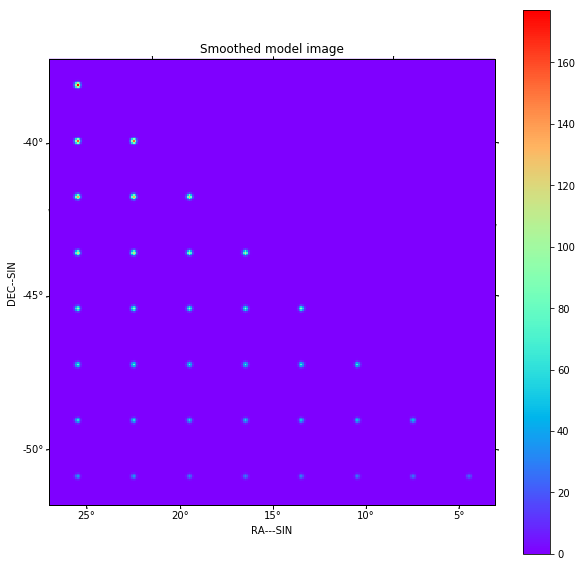

In [11]:
vt.data['vis'] *= 0.0
npixel=256

model = create_image_from_visibility(vt, npixel=npixel, cellsize=0.001, nchan=1, 
                                     polarisation_frame=PolarisationFrame('stokesI'))
centre = model.wcs.wcs.crpix-1
spacing_pixels = npixel // 8
log.info('Spacing in pixels = %s' % spacing_pixels)
spacing = model.wcs.wcs.cdelt * spacing_pixels
locations = [-3.5, -2.5, -1.5, -0.5, 0.5, 1.5, 2.5, 3.5]

original_comps = []
# We calculate the source positions in pixels and then calculate the
# world coordinates to put in the skycomponent description
for iy in locations:
    for ix in locations:
        if ix >= iy:
            p = int(round(centre[0] + ix * spacing_pixels * numpy.sign(model.wcs.wcs.cdelt[0]))), \
                int(round(centre[1] + iy * spacing_pixels * numpy.sign(model.wcs.wcs.cdelt[1])))
            sc = pixel_to_skycoord(p[0], p[1], model.wcs)
            log.info("Component at (%f, %f) [0-rel] %s" % (p[0], p[1], str(sc)))
            flux = numpy.array([[100.0 + 2.0 * ix + iy * 20.0]])
            comp = create_skycomponent(flux=flux, frequency=frequency, direction=sc, 
                                       polarisation_frame=PolarisationFrame('stokesI'))
            original_comps.append(comp)
            insert_skycomponent(model, comp)

predict_skycomponent_visibility(vt, original_comps)

        
cmodel = smooth_image(model) 
show_image(cmodel)
plt.title("Smoothed model image")
plt.show()

Check that the skycoordinate and image coordinate system are consistent by finding the point sources.

find_skycomponents: Finding components in Image by segmentation
find_skycomponents: Finding components in Image by segmentation
find_skycomponents: Identified 36 segments
find_skycomponents: Identified 36 segments


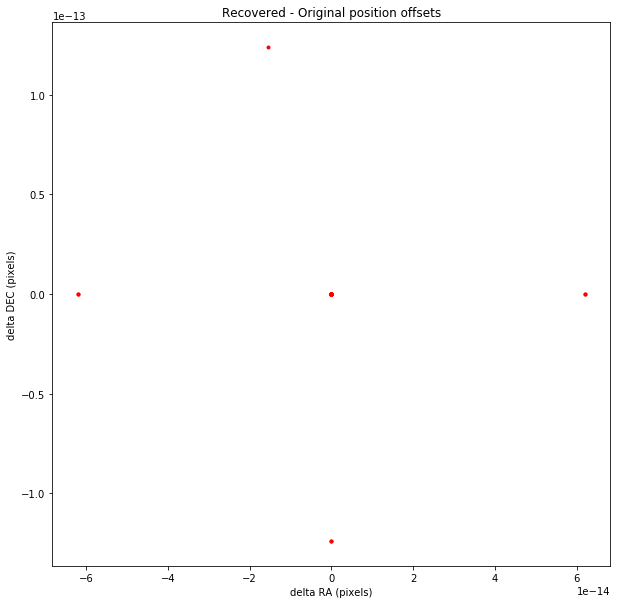

In [12]:
comps = find_skycomponents(cmodel, fwhm=1.0, threshold=10.0, npixels=5)
plt.clf()
for i in range(len(comps)):
    ocomp = find_nearest_component(comps[i].direction, original_comps)
    plt.plot((comps[i].direction.ra.value  - ocomp.direction.ra.value)/cmodel.wcs.wcs.cdelt[0], 
             (comps[i].direction.dec.value - ocomp.direction.dec.value)/cmodel.wcs.wcs.cdelt[1], 
             '.', color='r')  

plt.xlabel('delta RA (pixels)')
plt.ylabel('delta DEC (pixels)')
plt.title("Recovered - Original position offsets")
plt.show()

Predict the visibility using the different approaches.

In [13]:
from arl.imaging.imaging_context import imaging_contexts, predict_function, invert_function
contexts = imaging_contexts().keys()
print(contexts)

dict_keys(['2d', 'facets', 'facets_timeslice', 'facets_wstack', 'timeslice', 'wstack'])


In [ ]:
contexts = ['2d', 'facets', 'timeslice', 'wstack', 'wprojection']

for context in contexts:
    
    print('Processing context %s' % context)
   
    vtpredict = create_visibility(lowcore, times, frequency, channel_bandwidth=channel_bandwidth,
        weight=1.0, phasecentre=phasecentre, polarisation_frame=PolarisationFrame('stokesI'))

 
    if context == 'wprojection':       
        vtpredict = predict_function(vtpredict, model, context=context, wstep = advice['w_sampling_primary_beam'])
    
    elif context == 'facets':
        vtpredict = predict_function(vtpredict, model, context=context, facets=8)
        
    elif context == 'timeslice':
        vtpredict = predict_function(vtpredict, model, context=context, vis_slices=vis_timeslices(vis, 'auto'))

    elif context == 'wstack':
        vtpredict = predict_function(vtpredict, model, context=context, vis_slices=31)

    else:
        vtpredict = predict_function(vtpredict, model, context=context
                                     )

    uvdist = numpy.sqrt(vt.data['uvw'][:, 0] ** 2 + vt.data['uvw'][:, 1] ** 2)
    plt.clf()
    plt.plot(uvdist, numpy.abs(vt.data['vis'][:]), '.', color='r', label="DFT")
    
    plt.plot(uvdist, numpy.abs(vtpredict.data['vis'][:]), '.', color='b', label=context)
    plt.plot(uvdist, numpy.abs(vtpredict.data['vis'][:] - vt.data['vis'][:]), '.', color='g', label="Residual")
    plt.xlabel('uvdist')
    plt.ylabel('Amp Visibility')
    plt.legend()
    plt.show()


Make the image using the different approaches. We will evaluate the results using a number of plots:

- The error in fitted versus the radius. The ideal result is a straightline fitted: flux = DFT flux
- The offset in RA versus the offset in DEC. The ideal result is a cluster around 0 pixels.

The sampling in w is set to provide 2% decorrelation at the half power point of the primary beam.


In [ ]:
contexts = ['2d', 'facets', 'timeslice', 'wstack', 'wprojection']

for context in contexts:

    targetimage = create_image_from_visibility(vt, npixel=npixel, cellsize=0.001, nchan=1,
                                               polarisation_frame=PolarisationFrame('stokesI'))


    print('Processing context %s' % context)
    if context == 'wprojection':       
        targetimage, sumwt = invert_function(vt, targetimage, context=context, wstep = advice[
            'w_sampling_primary_beam'])
    
    elif context == 'facets':
        targetimage, sumwt = invert_function(vt, targetimage, context=context, facets=8)
        
    elif context == 'timeslice':
        targetimage, sumwt = invert_function(vt, targetimage, context=context, vis_slices=vis_timeslices(vis, 'auto'))

    elif context == 'wstack':
        targetimage, sumwt = invert_function(vt, targetimage, context=context, vis_slices=31)

    else:
        targetimage, sumwt = invert_function(vt, targetimage, context=context)

    show_image(targetimage)
    plt.title(context)
    plt.show()

    print("Dirty Image %s" % qa_image(targetimage, context="imaging-fits notebook, using processor %s" % context))

    export_image_to_fits(targetimage, '%s/imaging-fits_dirty_%s.fits' % (results_dir, context))
    comps = find_skycomponents(targetimage, fwhm=1.0, threshold=10.0, npixels=5)

    plt.clf()
    for comp in comps:
        distance = comp.direction.separation(model.phasecentre)
        dft_flux = sum_visibility(vt, comp.direction)[0]
        err = (comp.flux[0, 0] - dft_flux) / dft_flux
        plt.plot(distance, err, '.', color='r')
    plt.ylabel('Fractional error of image vs DFT')
    plt.xlabel('Distance from phasecentre (deg)')
    plt.title(
        "Fractional error in %s recovered flux vs distance from phasecentre" %
        context)
    plt.show()

    checkpositions = True
    if checkpositions:
        plt.clf()
        for i in range(len(comps)):
            ocomp = find_nearest_component(comps[i].direction, original_comps)
            plt.plot(
                (comps[i].direction.ra.value - ocomp.direction.ra.value) /
                targetimage.wcs.wcs.cdelt[0],
                (comps[i].direction.dec.value - ocomp.direction.dec.value) /
                targetimage.wcs.wcs.cdelt[1],
                '.',
                color='r')

        plt.xlabel('delta RA (pixels)')
        plt.ylabel('delta DEC (pixels)')
        plt.title("%s: Position offsets" % context)
        plt.show()